# **SENet**

# **Preprocessing**

In [15]:
import pandas as pd
import torch
import numpy as np

from PIL import Image
import pretrainedmodels
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [16]:
data = pd.read_csv('E:\\Studies\\Thesis\\Dataset\\FETAL_PLANES_ZENODO\\LR_merged.csv')

batch_size = 32

In [17]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [18]:
class UltrasoundDataset(Dataset):
    def __init__(self, data, transform=None):
        super().__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data.iloc[index]['Image_path']
        label = self.data.iloc[index]['Plane']

        # Debug print
        # print(f"Index: {index}, Label: {label}")

        label = int(label)  # Convert to integer

        image = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [19]:
le = LabelEncoder()
data['Plane'] = le.fit_transform(data['Plane'])

In [20]:
data = data.dropna(subset=['Image_path'])

# Splitting (80-10-10)
train_data_encoded, test_data_encoded = train_test_split(data, test_size=0.2, random_state=42)
train_data_encoded, val_data_encoded = train_test_split(train_data_encoded, test_size=0.2, random_state=42)

# Data loaders and transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = UltrasoundDataset(train_data_encoded, transform=transform)
val_dataset = UltrasoundDataset(val_data_encoded, transform=transform)
test_dataset = UltrasoundDataset(test_data_encoded, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


def convert_to_absolute_path(relative_path):
    return os.path.abspath(relative_path)

train_data_encoded['Image_path'] = train_data_encoded['Image_path'].apply(convert_to_absolute_path)
val_data_encoded['Image_path'] = val_data_encoded['Image_path'].apply(convert_to_absolute_path)
test_data_encoded['Image_path'] = test_data_encoded['Image_path'].apply(convert_to_absolute_path)

# **Loading Pretrained Model**

In [21]:
import ssl

# Disable SSL verification
ssl._create_default_https_context = ssl._create_unverified_context

# Load pre-trained model
model = pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=1000, pretrained='imagenet')

# Change last layer to match the number of classes
num_classes = len(data['Plane'].unique())
model.last_linear = nn.Linear(model.last_linear.in_features, num_classes)

# Loss function, optimizer, scheduler, device
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# **Model Train**

In [ ]:
n_epochs = 30
n_epochs_stop = 5  # Number of epochs with no improvement after which training will be stopped
min_val_loss = float('inf')
epochs_no_improve = 0  # The number of epochs with no improvement


train_accuracies = []
val_accuracies = []


# Training Loop
for epoch in range(n_epochs):

    # Current epoch number
    print(f"Epoch {epoch + 1}/{n_epochs}")

    model.train()

    # counters and accumulators for training metrics
    correct_train = 0
    total_train = 0
    train_loss = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training", ncols=100):

        inputs, labels = inputs.to(device), labels.to(device)       
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy = 100 * correct_train / total_train
    train_loss = train_loss / len(train_loader)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()

    # counters and accumulators for validation metrics
    correct_val = 0
    total_val = 0
    val_loss = 0

    with torch.no_grad():

        for inputs, labels in tqdm(val_loader, desc="Validation", ncols=100):

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

    val_loss = val_loss / len(val_loader)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%, Val Loss: {val_loss:.4f}")

    # Early stopping

    # If the validation loss is at a minimum
    if val_loss < min_val_loss:

        # Save model
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
        min_val_loss = val_loss

    else:
        epochs_no_improve += 1

        # Check early stopping condition
        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            break

    scheduler.step()


# **Prediction**

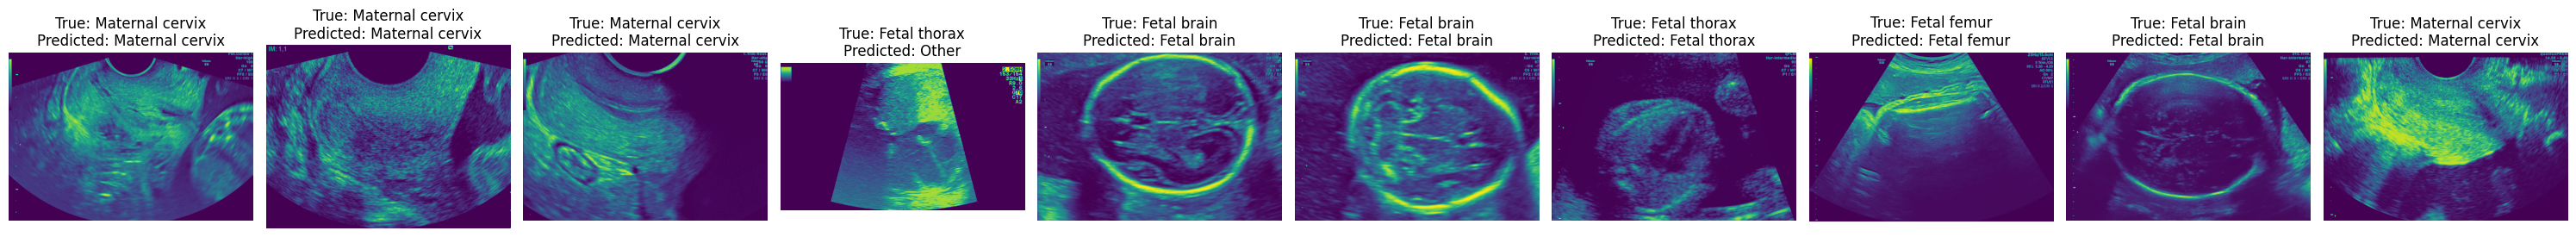

In [ ]:
# Load the best model
model_path = 'best_model.pt'
model.load_state_dict(torch.load(model_path))
model.eval()

# Make predictions on a few test images
def predict_image(image_path, model, device, transform, label_encoder):
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_idx = torch.max(output, 1)
        
    return predicted_idx.item()

num_images_to_show = 10
fig, axes = plt.subplots(1, num_images_to_show, figsize=(30, 30))

for i, row in enumerate(test_data_encoded.head(num_images_to_show).itertuples()):
    true_label = le.inverse_transform([row.Plane])[0]
    predicted_label_idx = predict_image(row.Image_path, model, device, transform, le)
    predicted_label_name = le.inverse_transform([predicted_label_idx])[0]
    
    img = Image.open(row.Image_path)
    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_label_name}")
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()



# **Accuracy and Graphs**

In [ ]:
def calculate_accuracy(dataloader, model, device):
    correct = 0
    total = 0
    model.eval()
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return 100 * correct / total

test_accuracy = calculate_accuracy(test_loader, model, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 91.45%


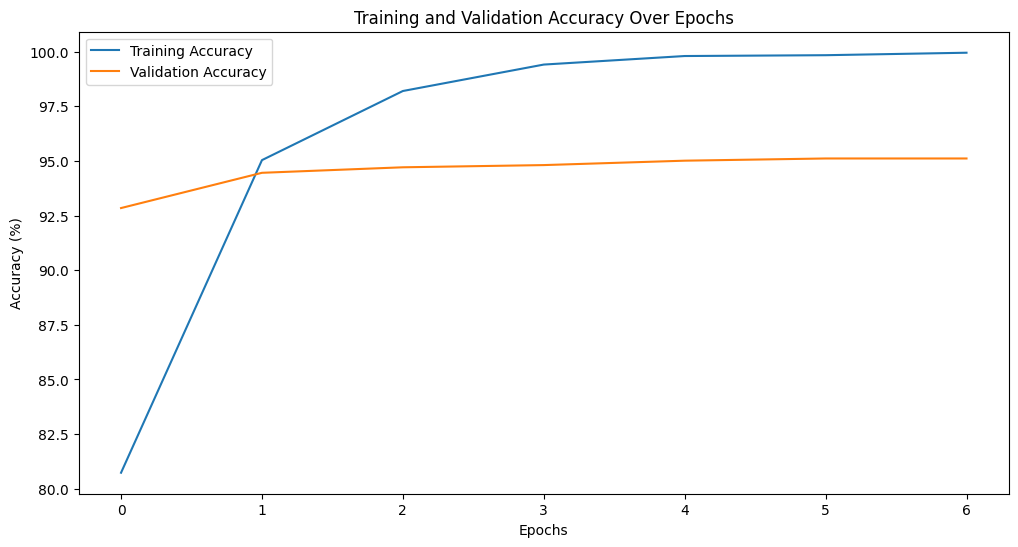

In [ ]:
# Plotting accuracies of SENet
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training and Validation Accuracy Over Epochs")
plt.show()

In [ ]:
def calculate_metrics(dataloader, model, device):
    y_true = []
    y_pred = []
    model.eval()
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred) * 100  
    precision = precision_score(y_true, y_pred, average='weighted') * 100  
    recall = recall_score(y_true, y_pred, average='weighted') * 100  
    f1 = f1_score(y_true, y_pred, average='weighted') * 100  

    # Print metrics
    print(f"Accuracy: {accuracy:.2f}%")  
    print(f"Precision: {precision:.2f}%")  
    print(f"Recall: {recall:.2f}%") 
    print(f"F1-Score: {f1:.2f}%")  


calculate_metrics(test_loader, model, device)


Accuracy: 91.45%
Precision: 91.70%
Recall: 91.45%
F1-Score: 91.36%


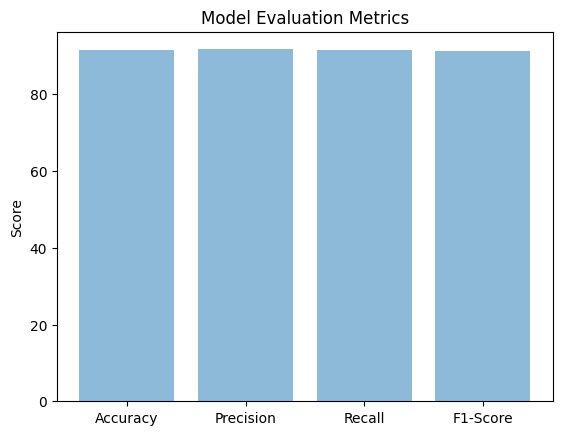

In [ ]:
def calculate_metrics(dataloader, model, device):
    y_true = []
    y_pred = []
    model.eval()
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred) * 100  
    precision = precision_score(y_true, y_pred, average='weighted') * 100  
    recall = recall_score(y_true, y_pred, average='weighted') * 100  
    f1 = f1_score(y_true, y_pred, average='weighted') * 100  

    # Store metrics in a list
    metrics = [accuracy, precision, recall, f1]

    # Create a list of metric names
    labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

    # Plotting
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, metrics, align='center', alpha=0.5)
    plt.xticks(y_pos, labels)
    plt.ylabel('Score')
    plt.title('Model Evaluation Metrics')

    plt.show()


calculate_metrics(test_loader, model, device)